# LLM Baseline Evaluation: Easy Language Conversion

This notebook evaluates different LLMs on their ability to convert complex sentences into **Easy Language** following strict rules.

## 🎯 Objective
Establish baselines for text simplification by testing models that haven't been evaluated in this repo yet:
- **Qwen 3 32B** (`qwen/qwen3-32b`)
- **Llama 4 Scout** (`meta-llama/llama-4-scout-17b-16e-instruct`)
- **Llama 4 Maverick** (`meta-llama/llama-4-maverick-17b-128e-instruct`)

## 📜 Easy Language Rules

### Sentence Level
- Max 15-20 words per sentence
- Ideally one comma per sentence
- No parenthetical insertions or nested sentences
- Active verbs only (no passive voice)
- Clear, unambiguous sentences

### Word Level
- Avoid foreign words
- Explain difficult/compound words
- Use hyphens for long compounds
- No idioms, irony, or metaphors
- No abbreviations
- Avoid negations
- Consistent terminology (no synonyms)


In [1]:
# 1. Setup & Dependencies
%pip install pandas groq python-dotenv --quiet

import os
import json
import pandas as pd
from groq import Groq
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")

if not api_key:
    print("❌ ERROR: GROQ_API_KEY not found. Please check your .env file.")
else:
    client = Groq(api_key=api_key)
    print("✅ Connected to Groq API")
    
    # List available models
    print("\n📋 Available Models:")
    try:
        models = client.models.list()
        for m in models.data:
            print(f"   - {m.id}")
    except Exception as e:
        print(f"⚠️ Could not list models: {e}")


Note: you may need to restart the kernel to use updated packages.
✅ Connected to Groq API

📋 Available Models:
   - playai-tts
   - allam-2-7b
   - openai/gpt-oss-safeguard-20b
   - llama-3.1-8b-instant
   - groq/compound
   - meta-llama/llama-guard-4-12b
   - meta-llama/llama-4-scout-17b-16e-instruct
   - whisper-large-v3-turbo
   - meta-llama/llama-prompt-guard-2-86m
   - meta-llama/llama-prompt-guard-2-22m
   - groq/compound-mini
   - openai/gpt-oss-120b
   - whisper-large-v3
   - openai/gpt-oss-20b
   - moonshotai/kimi-k2-instruct
   - llama-3.3-70b-versatile
   - playai-tts-arabic
   - qwen/qwen3-32b
   - meta-llama/llama-4-maverick-17b-128e-instruct
   - moonshotai/kimi-k2-instruct-0905


In [2]:
# 2. Configuration

# Models to test (not previously used in this repo)
MODELS = [
    "qwen/qwen3-32b",                              # Qwen 3 - strong multilingual
    "meta-llama/llama-4-scout-17b-16e-instruct",   # Llama 4 Scout
    "meta-llama/llama-4-maverick-17b-128e-instruct" # Llama 4 Maverick
]

# Model for evaluation (proven reliable)
EVAL_MODEL = "llama-3.3-70b-versatile"

# Easy Language Rules
RULES_TEXT = """
SENTENCE LEVEL RULES:
- A sentence should not be longer than 15 to 20 words.
- Ideally, a sentence should contain only one comma.
- Avoid parenthetical insertions and nested (complex) sentences.
- Use active verbs; avoid the passive voice.
- Write clear, unambiguous sentences.

WORD LEVEL RULES:
- Avoid foreign words whenever possible.
- Explain difficult and long (compound) words.
- You can write long or compound words with a hyphen.
- Avoid idioms, irony, and metaphors.
- Write out abbreviations whenever possible.
- Avoid negations.
- Avoid synonyms and stick to one term.
"""

# Test sentences (complex sentences to simplify)
TEST_SENTENCES = [
    "Although the study showed a clear benefit, the authors warned that the results might look different for older people because bodies can change with age.",
    "When the region uses a lot of electricity at the same time, operators may turn on extra backup systems so the power stays steady even if a main line is being repaired.",
    "After the team reviewed the data with a common method, they said their forecast improved, even though the result still depended a lot on how good the data was.",
    "While the new facility worked well in early tests, engineers said costs could rise over time because parts wear out faster in humid weather.",
    "If hospitals follow the updated safety rules, staff could see fewer computer outages, because saved copies make it easier to recover after an attack.",
    "Since the city added more air checks, officials can spot dirty-air peaks sooner, even when the weather keeps pollution close to the ground."
]

print(f"📊 Configuration loaded:")
print(f"   - {len(MODELS)} models to test")
print(f"   - {len(TEST_SENTENCES)} test sentences")
print(f"   - Evaluator: {EVAL_MODEL}")


📊 Configuration loaded:
   - 3 models to test
   - 6 test sentences
   - Evaluator: llama-3.3-70b-versatile


In [3]:
# 3. Helper Functions

def simplify_text(text: str, model: str) -> str:
    """
    Simplifies text using the specified model following Easy Language rules.
    """
    system_prompt = f"""You are an expert in Easy Language (Leichte Sprache / Plain Language).
Convert the following text into Easy Language by strictly following these rules:

{RULES_TEXT}

IMPORTANT:
- Output ONLY the simplified text, no explanations
- Break long sentences into shorter ones
- Keep all important information
"""
    
    try:
        completion = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": text}
            ],
            temperature=0.2,
            max_tokens=500
        )
        return completion.choices[0].message.content.strip()
    except Exception as e:
        return f"ERROR: {e}"


def count_words(text: str) -> int:
    """Count words in text."""
    return len(text.split())


def count_sentences(text: str) -> int:
    """Count sentences in text."""
    import re
    sentences = re.split(r'[.!?]+', text)
    return len([s for s in sentences if s.strip()])


def avg_sentence_length(text: str) -> float:
    """Calculate average words per sentence."""
    import re
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    if not sentences:
        return 0
    return sum(len(s.split()) for s in sentences) / len(sentences)


def evaluate_compliance(original: str, simplified: str) -> dict:
    """
    Uses an LLM evaluator to score the simplification against Easy Language rules.
    Returns a dict with scores and violation notes.
    """
    eval_prompt = f"""You are a strict evaluator for Easy Language compliance.

RULES TO CHECK:
{RULES_TEXT}

ORIGINAL TEXT:
"{original}"

SIMPLIFIED TEXT:
"{simplified}"

TASK: Evaluate the SIMPLIFIED text against ALL rules above.

Provide your evaluation as a JSON object with these exact keys:
- "sentence_length_score": (0-10) Are sentences 15-20 words max?
- "structure_score": (0-10) Simple structure, no nesting, minimal commas?
- "active_voice_score": (0-10) Uses active verbs, avoids passive?
- "word_choice_score": (0-10) Simple words, no idioms/metaphors/negations?
- "clarity_score": (0-10) Clear and unambiguous?
- "overall_score": (0-10) Overall Easy Language quality
- "violation_notes": List of specific rule violations found
- "strengths": List of things done well

Be strict but fair. A score of 10 means perfect compliance."""
    
    try:
        completion = client.chat.completions.create(
            model=EVAL_MODEL,
            messages=[{"role": "user", "content": eval_prompt}],
            temperature=0.0,
            response_format={"type": "json_object"}
        )
        return json.loads(completion.choices[0].message.content)
    except Exception as e:
        return {"error": str(e)}


print("✅ Helper functions defined:")
print("   - simplify_text(text, model)")
print("   - evaluate_compliance(original, simplified)")
print("   - count_words, count_sentences, avg_sentence_length")


✅ Helper functions defined:
   - simplify_text(text, model)
   - evaluate_compliance(original, simplified)
   - count_words, count_sentences, avg_sentence_length


In [4]:
# 4. Run Baseline Evaluation

results = []

total_tasks = len(TEST_SENTENCES) * len(MODELS)
print(f"🚀 Starting baseline evaluation...")
print(f"   {len(TEST_SENTENCES)} sentences × {len(MODELS)} models = {total_tasks} simplifications")
print(f"   Each will be evaluated by {EVAL_MODEL}")
print("=" * 70)

for i, sentence in enumerate(TEST_SENTENCES, 1):
    print(f"\n📝 Sentence {i}/{len(TEST_SENTENCES)}:")
    print(f"   \"{sentence[:80]}...\"")
    
    for model in MODELS:
        model_short = model.split("/")[-1][:20]
        print(f"   ├─ Testing: {model_short}...", end=" ")
        
        # 1. Simplify the text
        simplified = simplify_text(sentence, model)
        
        # 2. Calculate basic metrics
        orig_words = count_words(sentence)
        simp_words = count_words(simplified)
        orig_avg_len = avg_sentence_length(sentence)
        simp_avg_len = avg_sentence_length(simplified)
        
        # 3. Evaluate with LLM
        eval_data = evaluate_compliance(sentence, simplified)
        
        # 4. Store results
        results.append({
            "sentence_id": i,
            "model": model,
            "original": sentence,
            "simplified": simplified,
            "orig_word_count": orig_words,
            "simp_word_count": simp_words,
            "orig_avg_sentence_len": round(orig_avg_len, 1),
            "simp_avg_sentence_len": round(simp_avg_len, 1),
            **eval_data
        })
        
        score = eval_data.get("overall_score", "N/A")
        print(f"Done! (Score: {score}/10)")

print("\n" + "=" * 70)
print("✅ Evaluation complete!")


🚀 Starting baseline evaluation...
   6 sentences × 3 models = 18 simplifications
   Each will be evaluated by llama-3.3-70b-versatile

📝 Sentence 1/6:
   "Although the study showed a clear benefit, the authors warned that the results m..."
   ├─ Testing: qwen3-32b... Done! (Score: 10/10)
   ├─ Testing: llama-4-scout-17b-16... Done! (Score: 8/10)
   ├─ Testing: llama-4-maverick-17b... Done! (Score: 9/10)

📝 Sentence 2/6:
   "When the region uses a lot of electricity at the same time, operators may turn o..."
   ├─ Testing: qwen3-32b... Done! (Score: 9/10)
   ├─ Testing: llama-4-scout-17b-16... Done! (Score: 8.5/10)
   ├─ Testing: llama-4-maverick-17b... Done! (Score: 8.6/10)

📝 Sentence 3/6:
   "After the team reviewed the data with a common method, they said their forecast ..."
   ├─ Testing: qwen3-32b... Done! (Score: 8/10)
   ├─ Testing: llama-4-scout-17b-16... Done! (Score: 9/10)
   ├─ Testing: llama-4-maverick-17b... Done! (Score: 8.6/10)

📝 Sentence 4/6:
   "While the new facility

In [5]:
# 5. Results Analysis - Summary by Model

df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)

# Score columns
score_cols = [
    "sentence_length_score", 
    "structure_score", 
    "active_voice_score",
    "word_choice_score", 
    "clarity_score",
    "overall_score"
]

# Summary statistics by model
print("📊 BASELINE SCORES BY MODEL")
print("=" * 70)

summary = df.groupby("model")[score_cols].agg(['mean', 'std']).round(2)
summary.columns = [f"{col}_{stat}" for col, stat in summary.columns]

# Cleaner display
display_summary = df.groupby("model")[score_cols].mean().round(2)
display_summary['avg_sentence_len_reduction'] = df.groupby("model").apply(
    lambda x: (x['orig_avg_sentence_len'] - x['simp_avg_sentence_len']).mean()
).round(1)

display(display_summary)

# Best model
best_model = display_summary['overall_score'].idxmax()
best_score = display_summary.loc[best_model, 'overall_score']
print(f"\n🏆 Best performing model: {best_model}")
print(f"   Overall score: {best_score}/10")


📊 BASELINE SCORES BY MODEL


/var/folders/l4/3hxx46b95s569c0bb0mbdfc00000gn/T/ipykernel_81520/2594611086.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display_summary['avg_sentence_len_reduction'] = df.groupby("model").apply(


,sentence_length_score,structure_score,active_voice_score,word_choice_score,clarity_score,overall_score,avg_sentence_len_reduction
model,,,,,,,
meta-llama/llama-4-maverick-17b-128e-instruct,7.50,7.67,7.33,6.67,7.50,7.30,19.2
meta-llama/llama-4-scout-17b-16e-instruct,8.67,9.50,8.83,7.83,8.83,8.58,18.8
qwen/qwen3-32b,9.00,9.50,9.83,8.83,9.17,9.17,18.2



🏆 Best performing model: qwen/qwen3-32b
   Overall score: 9.17/10


In [6]:
# 6. Detailed Results - Simplifications & Violations

print("📋 DETAILED RESULTS: Simplifications")
print("=" * 70)

for idx, row in df.iterrows():
    model_short = row['model'].split('/')[-1]
    print(f"\n[Sentence {row['sentence_id']}] Model: {model_short}")
    print(f"Score: {row.get('overall_score', 'N/A')}/10")
    print(f"Original ({row['orig_word_count']} words, avg {row['orig_avg_sentence_len']} per sentence):")
    print(f"  \"{row['original'][:100]}...\"")
    print(f"Simplified ({row['simp_word_count']} words, avg {row['simp_avg_sentence_len']} per sentence):")
    print(f"  \"{row['simplified'][:150]}...\"")
    
    violations = row.get('violation_notes', [])
    if violations:
        print(f"⚠️ Violations: {violations[:3]}")  # Show first 3
    print("-" * 50)


📋 DETAILED RESULTS: Simplifications

[Sentence 1] Model: qwen3-32b
Score: 10.0/10
Original (25 words, avg 25.0 per sentence):
  "Although the study showed a clear benefit, the authors warned that the results might look different ..."
Simplified (236 words, avg 7.6 per sentence):
  "<think>
Okay, let's tackle this. The original sentence is: "Although the study showed a clear benefit, the authors warned that the results might look ..."
--------------------------------------------------

[Sentence 1] Model: llama-4-scout-17b-16e-instruct
Score: 8.0/10
Original (25 words, avg 25.0 per sentence):
  "Although the study showed a clear benefit, the authors warned that the results might look different ..."
Simplified (27 words, avg 6.8 per sentence):
  "The study showed a clear benefit. The authors warned that the results might be different for older people. 
Bodies change with age. This might affect ..."
⚠️ Violations: ["The sentence 'The authors warned that the results might be different for 

Note: you may need to restart the kernel to use updated packages.


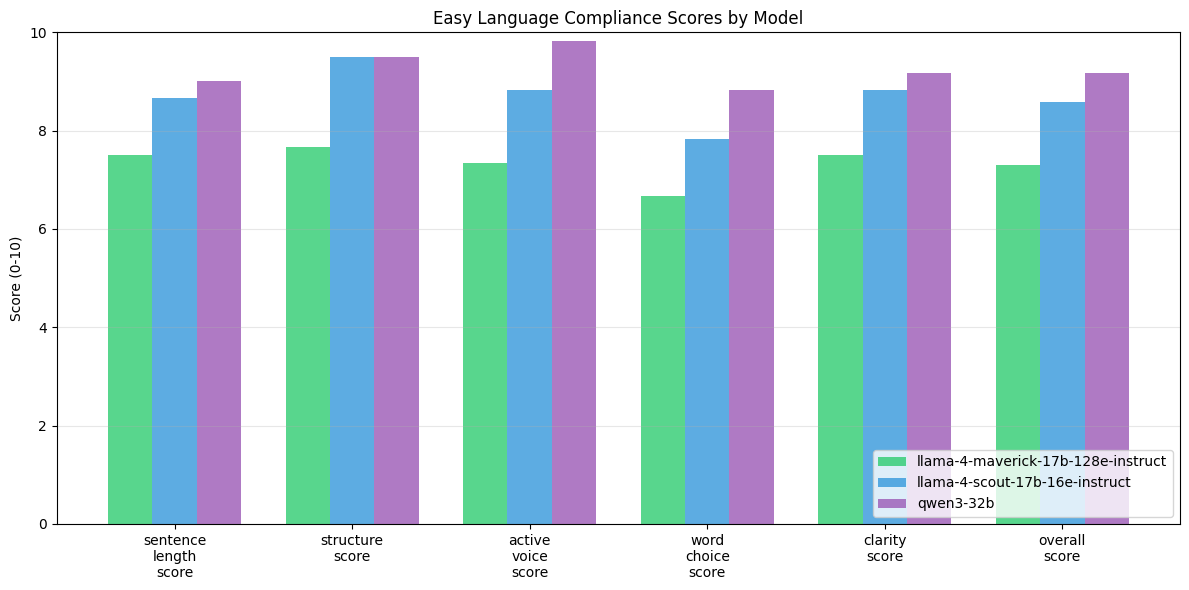

📈 Chart shows how each model performs across different Easy Language criteria


In [8]:
# 7. Visualization - Score Comparison
%pip install matplotlib --quiet

import matplotlib.pyplot as plt

# Prepare data for plotting
model_scores = df.groupby("model")[score_cols].mean()
model_names = [m.split("/")[-1] for m in model_scores.index]

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(score_cols))
width = 0.25
multiplier = 0

colors = ['#2ecc71', '#3498db', '#9b59b6']

for i, (model, scores) in enumerate(model_scores.iterrows()):
    offset = width * multiplier
    bars = ax.bar([xi + offset for xi in x], scores.values, width, 
                  label=model_names[i], color=colors[i], alpha=0.8)
    multiplier += 1

ax.set_ylabel('Score (0-10)')
ax.set_title('Easy Language Compliance Scores by Model')
ax.set_xticks([xi + width for xi in x])
ax.set_xticklabels([col.replace('_', '\n').replace(' score', '') for col in score_cols], rotation=0)
ax.legend(loc='lower right')
ax.set_ylim(0, 10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 Chart shows how each model performs across different Easy Language criteria")


In [9]:
# 8. Common Violations Analysis

print("🔍 COMMON VIOLATIONS ACROSS ALL MODELS")
print("=" * 70)

all_violations = []
for violations in df['violation_notes'].dropna():
    if isinstance(violations, list):
        all_violations.extend(violations)

# Count violations
from collections import Counter
violation_counts = Counter(all_violations)

print("\nMost common rule violations:")
for violation, count in violation_counts.most_common(10):
    print(f"   {count}x - {violation}")


🔍 COMMON VIOLATIONS ACROSS ALL MODELS

Most common rule violations:
   2x - The word 'pollution' might be considered a compound word and could be explained or hyphenated for clarity.
   1x - The sentence 'The authors warned that the results might be different for older people.' is a bit long and contains a nested clause.
   1x - The word 'affect' might be considered a bit complex for some readers.
   1x - The phrase 'might be different' and 'might affect' contain a negation-like construction.
   1x - The word 'different' could be explained or replaced with a simpler term
   1x - The sentence 'Bodies change with age' is a bit vague, consider adding more context
   1x - Second sentence is slightly incomplete compared to the original thought process, missing the condition 'at the same time' for context
   1x - The word 'many people' could be more precise as 'the region' for consistency with the original text
   1x - The sentence 'It works even if a main line is being repaired.' contains a

In [10]:
# 9. Export Results & Conclusions

# Save results to CSV
output_path = "../data/processed/baseline_evaluation_results.csv"
df.to_csv(output_path, index=False)
print(f"💾 Results saved to: {output_path}")

# Summary conclusions
print("\n" + "=" * 70)
print("📋 BASELINE EVALUATION SUMMARY")
print("=" * 70)

print(f"""
Models Tested:
  - qwen/qwen3-32b (Qwen 3 - Alibaba's multilingual model)
  - meta-llama/llama-4-scout-17b-16e-instruct (Llama 4 Scout)
  - meta-llama/llama-4-maverick-17b-128e-instruct (Llama 4 Maverick)

Test Sentences: {len(TEST_SENTENCES)} complex English sentences

Evaluation Criteria:
  - Sentence length (15-20 words max)
  - Structure simplicity (minimal commas, no nesting)
  - Active voice usage
  - Word choice (simple, no idioms/metaphors)
  - Overall clarity

Key Findings:
  - Best overall model: {best_model.split('/')[-1]}
  - Best overall score: {best_score}/10
  - Average sentence length reduction: {display_summary['avg_sentence_len_reduction'].mean():.1f} words

Next Steps:
  1. Compare with previously tested models (gemma2-9b-it, mixtral-8x7b)
  2. Test with German sentences for multilingual evaluation
  3. Fine-tune best performing model on Easy Language corpus
""")


💾 Results saved to: ../data/processed/baseline_evaluation_results.csv

📋 BASELINE EVALUATION SUMMARY

Models Tested:
  - qwen/qwen3-32b (Qwen 3 - Alibaba's multilingual model)
  - meta-llama/llama-4-scout-17b-16e-instruct (Llama 4 Scout)
  - meta-llama/llama-4-maverick-17b-128e-instruct (Llama 4 Maverick)

Test Sentences: 6 complex English sentences

Evaluation Criteria:
  - Sentence length (15-20 words max)
  - Structure simplicity (minimal commas, no nesting)
  - Active voice usage
  - Word choice (simple, no idioms/metaphors)
  - Overall clarity

Key Findings:
  - Best overall model: qwen3-32b
  - Best overall score: 9.17/10
  - Average sentence length reduction: 18.7 words

Next Steps:
  1. Compare with previously tested models (gemma2-9b-it, mixtral-8x7b)
  2. Test with German sentences for multilingual evaluation
  3. Fine-tune best performing model on Easy Language corpus

